In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [2]:
data_path = 'dataset'
img_path = list(paths.list_images(data_path))

In [3]:
imgs = []
labels = []
for img in img_path:
    label = img.split(os.path.sep)[-2]
    img  = cv2.resize(cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB), (224,224))
    imgs.append(img)
    labels.append(label)
    

In [4]:
imgs = np.array(imgs) / 225.0
labels = np.array(labels)

In [5]:
lb = LabelBinarizer()

In [6]:
labels = to_categorical(lb.fit_transform(labels))

In [7]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [8]:
(train_x, test_x,  train_y, test_y) = train_test_split(imgs,labels, test_size=0.20, stratify=labels, random_state=42)

In [9]:
print(train_x.shape)
print(test_x.shape)
print(train_y.shape)
print(test_y.shape)

(40, 224, 224, 3)
(10, 224, 224, 3)
(40, 2)
(10, 2)


In [10]:
train_aug = ImageDataGenerator(
    rotation_range=15,
    fill_mode="nearest")

In [11]:
b_m = VGG16(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))

In [12]:
h_m = b_m.output
h_m = AveragePooling2D(pool_size=(4,4))(h_m)
h_m = Flatten(name='flatten')(h_m)
h_m = Dense(64, activation='relu')(h_m)
h_m = Dropout(0.5)(h_m)
h_m = Dense(2, activation='softmax')(h_m)

m = Model(inputs=b_m.input, outputs=h_m)

for l in b_m.layers:
    l.trainable = False


In [13]:
m.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [14]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
m.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])


In [15]:
H = m.fit_generator(
    train_aug.flow(train_x,train_y, batch_size=BS),
    steps_per_epoch=len(train_x) // BS,
    validation_data=(test_x, test_y),
    validation_steps=len(test_x) // BS,
    epochs=EPOCHS)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 3s 534ms/step - loss: 0.7287 - accuracy: 0.5500 - val_loss: 0.5944 - val_accuracy: 0.5000
Epoch 2/25
5/5 [==============================] - 0s 96ms/step - loss: 0.7236 - accuracy: 0.5250 - val_loss: 0.5562 - val_accuracy: 0.6250
Epoch 3/25
5/5 [==============================] - 0s 96ms/step - loss: 0.6997 - accuracy: 0.5000 - val_loss: 0.5459 - val_accuracy: 0.5000
Epoch 4/25
5/5 [==============================] - 0s 96ms/step - loss: 0.6605 - accuracy: 0.5750 - val_loss: 0.5305 - val_accuracy: 0.6250
Epoch 5/25
5/5 [==============================] - 0s 96ms/step - loss: 0.7240 - accuracy: 0.5750 - val_loss: 0.5162 - val_accuracy: 0.6250
Epoch 6/25
5/5 [==============================] - 0s 97ms/step - loss: 0.6102 - accuracy: 0.6750 - val_loss: 0.5046 - val_accuracy: 0.6250
Epoch 7/25
5/5 [======

In [16]:
prd = m.predict(test_x, batch_size=BS)
prd = np.argmax(prd, axis=1)

print(classification_report(test_y.argmax(axis=1), prd, target_names=lb.classes_))


              precision    recall  f1-score   support

       covid       1.00      1.00      1.00         5
      normal       1.00      1.00      1.00         5

    accuracy                           1.00        10
   macro avg       1.00      1.00      1.00        10
weighted avg       1.00      1.00      1.00        10



In [17]:
predIdxs = m.predict(test_x, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

cm = confusion_matrix(test_y.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [0 5]]
acc: 1.0000
sensitivity: 1.0000
specificity: 1.0000


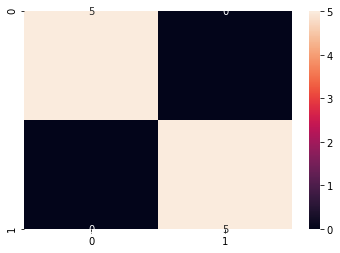

In [18]:
import seaborn as sns
sns.heatmap(cm, annot=True)

[INFO] saving COVID-19 detector model...


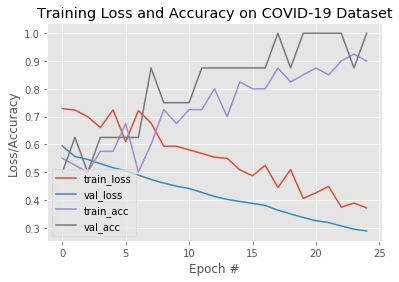

In [19]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
m.save('covid_19_vgg16.h5')